<a href="https://colab.research.google.com/github/abhayratti/Titanic-Classification-Model/blob/main/Titanic_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data = data.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1)
data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()

data['Sex'] = le.fit_transform(data['Sex'])
data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [ ]:
features = ['Pclass', 'Sex', 'Age', 'Fare']
data_features = data[features]

data_features.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


In [ ]:
data_features = pd.get_dummies(data_features, columns=['Pclass'])

data_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [ ]:
data_target = data[['Survived']]

data_target.head() # 0 - dead | 1 - survived

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, x_test, Y_train, y_test = train_test_split(data_features,
                                                    data_target,
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
X_train.shape, Y_train.shape

((571, 6), (571, 1))

In [ ]:
import torch
import numpy as np

In [ ]:
Xtrain_ = torch.from_numpy(X_train.values).float()
Xtest_ = torch.from_numpy(x_test.values).float()

In [ ]:
Xtrain_.shape, Xtest_.shape

(torch.Size([571, 6]), torch.Size([143, 6]))

In [ ]:
# reshape data to match y-label format for our loss function (NLL)
Ytrain_ = torch.from_numpy(Y_train.values).view(1,-1)[0] # ".view(1,-1)[0] extracts y-labels as a 1D tensor"
Ytest_ = torch.from_numpy(y_test.values).view(1,-1)[0]

In [ ]:
Ytrain_.shape, Ytest_.shape

(torch.Size([571]), torch.Size([143]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
input_size = 6
output_size = 2 # survived or not
hidden_one_size = 20
hidden_two_size = 10

In [ ]:
# structure of NN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_one_size)
    self.fc2 = nn.Linear(hidden_one_size, hidden_two_size)
    self.fc3 = nn.Linear(hidden_two_size, output_size)
  
  def forward(self, x):
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=-1)

In [ ]:
# start a model of this NN
model = Net()

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

loss_fn = nn.NLLLoss()

In [ ]:
# training
epoch_data = []
epochs = 1001

In [ ]:
for i in range (1, 2):
  optimizer.zero_grad()
  Ypred = model(Xtrain_)

  print(Ypred.shape, Ytrain_.shape)

torch.Size([571, 2]) torch.Size([571])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
for epoch in range(1, epochs):
  # forward pass
  optimizer.zero_grad() # refreshing the grads for every forward pass
  Ypred = model(Xtrain_)

  # backward pass
  loss = loss_fn(Ypred, Ytrain_) # calculate loss
  loss.backward() # calculate gradients

  optimizer.step() # update params

  # testing data
  Ypred_test = model(Xtest_)
  loss_test = loss_fn(Ypred_test, Ytest_)

  _, pred = Ypred_test.data.max(1)

  # accuracy
  p1 = pred.eq(Ytest_.data).sum().item()
  p2 = y_test.values.size
  print(p1, p2, 'Accuracy: ', p1 / p2)

  # accuracy = pred.eq(Ytest_.data).sum().item() / y_test.values.size
  # epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])

  # if epoch % 100 == 0:
  #   print ('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f' \
  #          % (epoch, epoch/150 * 10 , loss.data.item(), loss_test.data.item(), accuracy))

64 143 Accuracy:  0.44755244755244755
59 143 Accuracy:  0.4125874125874126
74 143 Accuracy:  0.5174825174825175
89 143 Accuracy:  0.6223776223776224
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524
79 143 Accuracy:  0.5524475524475524


In [ ]:
df_epochs_data = pd.DataFrame(epoch_data, columns=['epoch', 'train_loss', 'test_loss', 'accuracy'])

In [ ]:
import matplotlib.pyplot as plt

TypeError: ignored

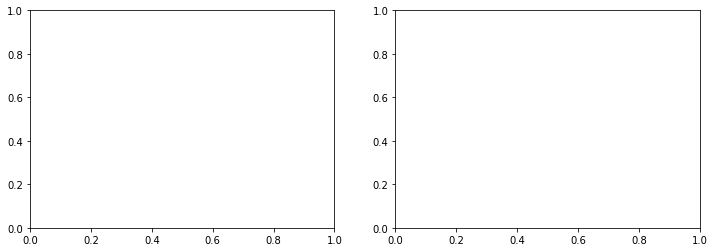

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[['train_loss', 'test_loss']].plot(ax=ax1)
df_epochs_data[['accuracy']].plot(ax=ax2)
plt.ylim(ymin=0.5)

plt.show()